In [1]:
import numpy as np
from operator import itemgetter
from scipy.sparse.linalg import eigs
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
class MarkovChain:
    
    def __init__(self,match_path,t2i_path,dim,timestep):
        self.match_path = match_path
        self.t2i_path = t2i_path
        self.dim = dim
        self.timestep = timestep
    
    def get_transition_matrix(self):
        self.M = np.zeros((self.dim, self.dim))
        with open(self.match_path,'r') as f:
            matches = f.readlines()
        for match in matches:
            A_idx, A_pts, B_idx, B_pts = list(map(int, match.split(',')))
            A_idx-=1
            B_idx-=1
            total_pts = A_pts + B_pts
            
            if A_pts > B_pts:
                self.M[A_idx][A_idx] = 1 + (A_pts/total_pts)
                self.M[B_idx][A_idx] = 1 + (A_pts/total_pts)
                self.M[B_idx][B_idx] = 0 + (B_pts/total_pts)
                self.M[A_idx][B_idx] = 0 + (B_pts/total_pts)
            else:
                self.M[A_idx][A_idx] = 0 + (A_pts/total_pts)
                self.M[B_idx][A_idx] = 0 + (A_pts/total_pts)
                self.M[B_idx][B_idx] = 1 + (B_pts/total_pts)
                self.M[A_idx][B_idx] = 1 + (B_pts/total_pts)
        
        self.M /=  self.M.sum(axis=1)[:,np.newaxis]
    
    def idx2team(self):
        with open(self.t2i_path,'r') as f:
            self.teams = [row.strip() for row in f.readlines()]
    
    def get_w_inf(self):
        vec = eigs(self.M,1)[1]
        return vec.T / sum(vec)
        
    def fit(self):
        self.get_transition_matrix()
        self.idx2team()
        w0 = np.random.uniform(size=self.dim)
        self.team_scores = []
        
        temp = w0
        for i in tqdm(range(0,len(self.timestep))):
            w_t_i = np.matmul(temp,self.M)
            temp = w_t_i
            self.team_scores.append(w_t_i)
        
        self.w_inf = self.get_w_inf()
        
    def get_top_teams(self,top=25):
        result = []
        for i in self.team_scores:
            top_team_idx = i.argsort()[-top:][::-1]
            result.append(tuple(itemgetter(*top_team_idx+1)(self.teams))) 
        return result

In [14]:
mc = MarkovChain('../data/CFB2019_scores.csv','../data/TeamNames.txt',769,[10,100,1000,10000])

In [15]:
mc.fit()

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4207.98it/s]


In [16]:
teams = mc.get_top_teams()

In [6]:
mc_inf = MarkovChain('../data/CFB2019_scores.csv','../data/TeamNames.txt',769,np.arange(1,10001))
mc_inf.fit()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 15169.41it/s]


In [7]:
y = []
for i in mc_inf.team_scores:
    y.append(np.linalg.norm((i-mc_inf.w_inf),ord=1))

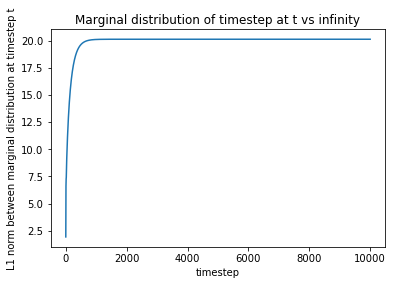

In [8]:
plt.plot(np.arange(1,10001),y)
plt.ylabel('L1 norm between marginal distribution at timestep t')
plt.xlabel('timestep')
plt.title('Marginal distribution of timestep at t vs infinity')
plt.show()

In [12]:
np.linalg.norm((np.array([1,2,3]) - np.array([0,0,0])),ord=1)

6.0